# Merging Train and Test for cleaning
The steps for cleaning were determined in Notebook 1.  Here I retroactively adopt the approach of knitting the train and test sets together and cleaning them simultaneously instead of side by side.  Since cleaning steps were determined blind (no imported test data), decisions were not influenced by data leakage, but extra care is taken to keep train and test data identified and separated from each other in this aggregate cleaning.

In [439]:
import numpy as np
import pandas as pd
import scipy as stats
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

## Citations
Source 1: 'Intermediate Data Cleaning' by Kevin Crystal, GA-DSI alumn
- https://medium.com/@kevin.a.crystal/intermediate-data-cleaning-195e1af3ccf9
- Mostly used for conceptual approach to cleaning.  Noted in code notes if actual code used.


Source 2: 'Comprehensive data exploration with Python' by Pedro Marcelino
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
- ripped code to print df of nulls and what % of the column those nulls represent


Source 3: 'A study on Regression applied to the Ames dataset' by Julien Cohen Solal
- https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

Source 4: 'Regularized Linear Models' by Alexandru Papiu
- https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models

Source 5: 'Stacked Regressions: Top 4% on Leaderboard' by Serigne
- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

Source 6: 'How to not fail this project' by Gwen Rathgerber
- process for creating dummy model
- idea for stretching the scale of ordinal variables

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [3]:
training = pd.read_csv('./datasets/train.csv')
testing = pd.read_csv('./datasets/test.csv')

In [4]:
print(training.shape, testing.shape)

(2051, 81) (878, 80)


In [5]:
training.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [40]:
#training.info()

In [7]:
#are df formats parallel for concatenating?
training_compare = training.drop(columns='SalePrice')
print(f'Starting with same columns?: {training_compare.columns.equals(testing.columns)}')
print(f'Columns same datatype?: {training_compare.dtypes.equals(testing.dtypes)}')  
#FALSE: at first glance, many ints as floats, which is fine
#confirm all 'objects' are same
train_types=training_compare.select_dtypes(include = 'object').columns
test_types=testing.select_dtypes(include = 'object').columns
print(f"'Object' columns same in each df?: {train_types.equals(test_types)}")

Starting with same columns?: True
Columns same datatype?: False
'Object' columns same in each df?: True


In [8]:
#nulls and what % of factor, code from Source 2
nulls= training.isnull().sum().sort_values(ascending=False)
perc= (training.isnull().sum()/training.isnull().count()).sort_values(ascending=False)
missing_train= pd.concat([nulls, perc],axis=1, keys=['# nulls', '% null'])
missing_train.head(27)

,# nulls,% null
Pool QC,2042,0.995612
Misc Feature,1986,0.968308
Alley,1911,0.931741
Fence,1651,0.804973
Fireplace Qu,1000,0.487567
Lot Frontage,330,0.160897
Garage Finish,114,0.055583
Garage Cond,114,0.055583
Garage Qual,114,0.055583
Garage Yr Blt,114,0.055583


# Pre-pre processing
A. snakecase that nonsense

B. Per the 'Special Notes' in the data dictionary, there are true outliers in the data that are evident upon graphing Saleprice and 'Gr Liv Area'.  The provider of the dataset recommends removing any houses with more than 4000 sqft from the data.  Perform this filter before merging with testing data.

C. Note in the above table that over 90% of the Pool QC, Misc Features, and Alley columns are null / empty.  This likely indicates no pool, misc feature, or alley, but either way these columns are not particularly informative.  Consider dropping in future.

In [9]:
#snakecase columns
training.columns = training.columns.str.lower().str.replace(" ","_")
testing.columns = testing.columns.str.lower().str.replace(" ","_")

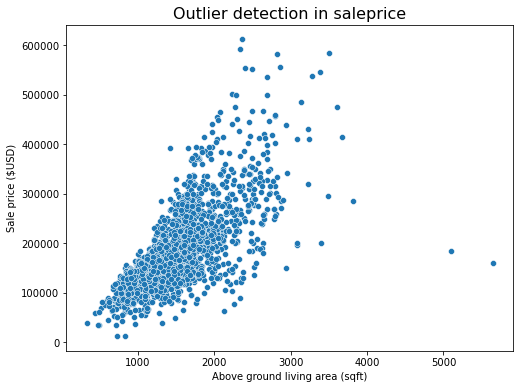

In [10]:
#look at those weirdos out there on the right
plt.figure(figsize=(8,6))
sns.scatterplot(x='gr_liv_area',y='saleprice',data=training);
plt.xlabel('Above ground living area (sqft)')
plt.ylabel('Sale price ($USD)')
plt.title('Outlier detection in saleprice', size=16);

In [11]:
#remove outliers by implementing recommended 4000sqft threshold
training = training[training['gr_liv_area']<4000]

## Merge train and test for synchronized cleaning
Separate saleprice (y_train) so train and test are the same shape.

In [12]:
#add identifier
training['is_train'] = 1
testing['is_train'] = 0

In [13]:
training.head(2)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,is_train
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500,1
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000,1


In [14]:
testing.head(2)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,is_train
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD,0
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,0


In [15]:
#merge all but saleprice
allofit = pd.concat((training.drop(columns='saleprice'), testing))

In [16]:
#allofit.head()

### False Nulls
According to the data dictionary, 'NA' can be used to indicate that a particular property attribute does not exist, amidst an otherwise ordinal list of ranking that attribute.  For instance, 'Rating of basement finished area' is on a scale of Unfinished up to Good Living Quarters, with NA indicating that there is no basement.  In this scenario, NA can = 0, Unfinished = 1, and Good Living Quarters = max.

NA is defined as its own level of ordinal rank (0) in the case of 12 variables.  Many of these share the same 6-level scale (NA, Po, Fa, TA, Gd, Ex).  They also share this scale with other ordinal variables in the dataset that do not contain (or define) NA.  I will convert all of these to a numeric scale together, with Na=0 to Ex=5.  

The Pool variable has all of these levels except for 'Po'; I will still include it in this same scale and just record 0 entries at (Po:1).  Apparently in Ames, any pool is already considered 'Fair', but as a water sport athlete I can tell you there are DEFINITELY 'Poor' pools and Ames county is ignoring a valuable metric.

---
### Not so false nulls


Other vars in the data dictionary were NOT stipulated to have meaningful NaNs.  I initially ran them through the same function to convert since there WERE no nulls, so it didn't matter that they were getting replaced with 0.  However, if the TEST data has nulls there, then I'm potentially messing with distribution.  For these vars (lot shape, utilities, land slope, electrical, functional), replace (hypothetical) nulls with the median of the training data.

In [17]:
#cols needing transform from (ordinal) object to numeric
nans_to_zeros = ['bsmt_qual','bsmt_cond', 'fireplace_qu','garage_qual', 'garage_cond',
                 'kitchen_qual', 'exter_qual','exter_cond','heating_qc','garage_finish', 
                 'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2', 'pool_qc', 'fence']

nans_to_median = ['lot_shape','utilities','land_slope', 'electrical','functional']

In [18]:
to_num_masterdict={'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, #nans_to_zeros cols.
'Unf':1, 'RFn':2, 'Fin':3, #garage_finish
'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4, #fence
'No':1, 'Mn':2, 'Av':3, 'Gd':4,#bsmt_exposure
'Unf':1, 'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6, #bsmtfin_type_1 and 2
'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4, #lot_shape
'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4, #utilities
'Sev':1, 'Mod':2, 'Gtl':3, #land_slope
'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7, #functional
'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5} #electrical

In [19]:
#conversion function
def to_nums_fillna0(df, targetcols):
    for i in targetcols:
        df[i] = df[i].map(to_num_masterdict)
        df[i] = df[i].fillna(0) #no need inplace=T because assigning with =
        #print(df[targetcols].value_counts()) #this line to check work, from source1

In [20]:
to_nums_fillna0(allofit, nans_to_zeros)

In [22]:
def to_nums_fillna_median(df, targetcols):
    for i in targetcols:
        df[i] = df[i].map(to_num_masterdict)
        df[i] = df[i].fillna(allofit.loc[allofit['is_train']==1][i].median())

In [23]:
to_nums_fillna_median(allofit, nans_to_median)

In [36]:
#allofit[nans_to_zeros].dtypes  #check now numeric - yes

In [35]:
#allofit[nans_to_median].dtypes  #check now numeric - yes
#allofit[nans_to_median].isnull().sum() #no NaNs

lot_shape     0
utilities     0
land_slope    0
electrical    0
functional    0
dtype: int64

In [34]:
#allofit.loc[allofit['is_train']==1].isnull().sum().sort_values(ascending=False).head(17)

## Nominal variables
Nominal variables with a NA definition, according to the data dictionary, are:  
- Alley (Grvl, Pave, NA)
- Garage Type (2Types, Attchd, Basment, BuiltIn, CarPort, Detchd, NA)
- Misc Feature (Elev, Gar2, Othr, Shed, TenC, NA)
- Masonry Veneer Type - not defined as such, but NaNs assumed to be 'no veneer', esp since they all correspond with NaNs for veneer square feet (training data only)
---
#### Remember:
Alley and Misc Feature initially had over 92% null values (training data only).  They are in consideration for dropping altogether.  For now, clean.

In [27]:
def nans2none_nominal(df, targetcols):
    for i in targetcols:
        df[i] = df[i].fillna('None')
        
nominal_nans = ['alley','misc_feature','garage_type','mas_vnr_type']
nans2none_nominal(allofit, nominal_nans)

In [33]:
#allofit.loc[allofit['is_train']==1].isnull().sum().sort_values(ascending=False).head(17)

## Remaining nulls:
* Lot Frontage: is continuous linear feet of street connected to property.  Fillna's with median.

* Garage Yr Built: could fill nas with year of property build or remodel, but no novel information there.  There are six other variables about garages that will conserve the important features (existence, sqft, finish).  Drop Garage yr built; that info will be conserved and it's likely just causing collinearity.

* Mas Vnr Area: all corresponded with NaN for veneer type, so assumed no veneer.  Fill with 0s.

* Like Masonry Veneer, the single digit basement and garage nulls all occur in listings that have no basement or garage, respectively.  Replace with 0s.

In [29]:
allofit['lot_frontage'] = allofit['lot_frontage'].fillna(allofit.loc[allofit['is_train']==1]['lot_frontage'].median())

In [30]:
allofit.drop(columns='garage_yr_blt', inplace=True)

In [31]:
continuous_fill_0 = ['mas_vnr_area','bsmt_half_bath','bsmt_full_bath','bsmtfin_sf_1',
                         'bsmtfin_sf_2','total_bsmt_sf','bsmt_unf_sf','garage_cars','garage_area']

allofit[continuous_fill_0] = allofit[continuous_fill_0].fillna(0)

In [38]:
#source 2
nulls= allofit.isnull().sum().sort_values(ascending=False)
perc= (allofit.isnull().sum()/allofit.isnull().count()).sort_values(ascending=False)
missing_data= pd.concat([nulls, perc],axis=1, keys=['# nulls', '% null'])
missing_data.head()

,# nulls,% null
is_train,0,0.0
sale_type,0,0.0
year_remod/add,0,0.0
roof_style,0,0.0
roof_matl,0,0.0


## Identify binary categories and reformat as numeric
* 'Central air' just has Y and N entries.  Change to 1,0 (essentially same as dummifying + drop_first).  
* 'Paved drive' has Yes, No, and Partial entries.  To binarize, will include Partial into Yes.  
* 'Masonry veneer type' is awfully specific.  Let's reduce to has (1) or has not (0) veneer.

In [39]:
allofit['central_air'] = allofit['central_air'].map({'Y':1, 'N':0})
allofit['paved_drive'] = allofit['paved_drive'].map({'Y':1, 'P':1, 'N':0})
allofit['mas_vnr_type'] = allofit['mas_vnr_type'].map({'BrkFace':1, 'Stone':1, 'BrkCmn':1,
                                                'CBlock':1, 'None':0})

## Stretch ordinal scales
Source Gwen: take the numerical variables that represent discrete scales and square the values, forcing the regression to reward higher scores more than a stepwise 0-5 scale.

* Variables in this list include everything transformed in the above category-to-numeric functions, + Overall Quality and Overall Condition

In [44]:
#numeric vars on discrete scales
discretios = ['bsmt_qual','bsmt_cond', 'fireplace_qu','garage_qual', 'garage_cond',
              'kitchen_qual', 'exter_qual','exter_cond','heating_qc','garage_finish', 
              'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2', 'pool_qc', 'fence', #nans_to_zeros
              'lot_shape','utilities','land_slope', 'electrical','functional', #nans_to_median
              'overall_qual', 'overall_cond'] #additional

In [47]:
allofit[discretios] = allofit[discretios].apply(lambda x: x*x)

## Trim the fat
No action here for now.  After investigating correlation and running some base models, revisit here to drop columns for future models.  On the docket:
- Alley, Pool QC: >90% 0 values
- Misc Feature: >90% 0's, and Misc Val still exists
- PID: irrelevant to prediction
- Masonry Veneer Area or Type: drop one or the other
- Basement Finish Type 2, sqft 2, unfinished sqft: excessive basement metrics
- Fireplaces: 'Fireplace Qual' already has 0 for no fireplace so is an indicator and scale
- Garage condition: collinear with garage quality
- 3 season porch, Screen porch: excessive porch metrics

## Dummify categorical vars: Drop_first = False
#### source 3, 4
I thought I'd be expected to pick the important ones through some research or instinct, but kaggle practice seems to be DUMMIFY EVERYTHING.  I'm for it. Let's go.

Drop_first = False or else you create a weird hypothetical 'reference' property comprising the features of all the reference columns.  Then your correlations are all in reference to that frankenlisting.

In [49]:
#separate numerical and categorical vars
cats = allofit.select_dtypes(include= ['object']).columns
nums = allofit.select_dtypes(exclude= ['object']).columns
all_cats = allofit[cats]
all_nums = allofit[nums]

In [52]:
#all_cats.head()

,ms_zoning,street,alley,land_contour,lot_config,neighborhood,condition_1,condition_2,bldg_type,house_style,roof_style,roof_matl,exterior_1st,exterior_2nd,foundation,heating,garage_type,misc_feature,sale_type
0,RL,Pave,None,Lvl,CulDSac,Sawyer,RRAe,Norm,1Fam,2Story,Gable,CompShg,HdBoard,Plywood,CBlock,GasA,Attchd,None,WD
1,RL,Pave,None,Lvl,CulDSac,SawyerW,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,GasA,Attchd,None,WD
2,RL,Pave,None,Lvl,Inside,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,CBlock,GasA,Detchd,None,WD
3,RL,Pave,None,Lvl,Inside,Timber,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,GasA,BuiltIn,None,WD
4,RL,Pave,None,Lvl,Inside,SawyerW,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,Plywood,PConc,GasA,Detchd,None,WD


In [53]:
all_cats = pd.get_dummies(all_cats, drop_first=False)

In [54]:
#remerge with numericals - NOT transformed for now
allofit_dum = pd.concat([all_nums, all_cats], axis=1)

In [213]:
allofit_dum.shape #combined train/test data + dummies of categories, clean
allofit_basic_clean = allofit_dum.copy()

## Log transform target: saleprice
This makes the features more normal, ala the before and after histograms below.  "Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally. (source 3)."  Log transformation should be used on highly skewed distributions to make outliers less influential, and make patterns more interpretable.

#### Merge transformed saleprice with just the cleaned training set for correlation analysis

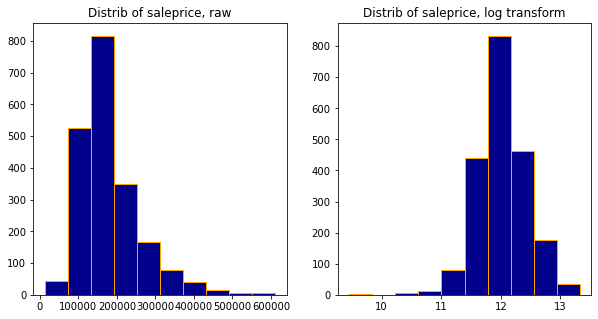

In [59]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('Distrib of saleprice, raw')
ax1.hist(training['saleprice'], color = 'darkblue', ec='orange');

ax2 = plt.subplot(1,2,2)
ax2.set_title('Distrib of saleprice, log transform')
ax2.hist(np.log1p(training['saleprice']),color='darkblue', ec='orange');

In [81]:
y = np.log1p(training['saleprice'])

# RESPLIT TRAIN AND TEST

In [109]:
training_dum = pd.concat([allofit_dum.loc[allofit_dum['is_train']==1],y], axis=1)
testing_clean = allofit_dum.loc[allofit_dum['is_train'] != 1]

In [113]:
# print(training_dum.shape)
# training_dum.head()
# testing_clean.shape
# training_dum.isnull().sum().sort_values(ascending=False)
# testing_clean.isnull().sum().sort_values(ascending=False) #zeros for days


## Correlation
Now that things are clean(er), let's look at correlation of numeric vars. Heatmap is overwhelming because overloaded, but can pick out heaviest hitters for saleprice.

My first approach would be to select the most strongly correlated variables, and pare them down further by trying to eliminate collinearity (ie garage sqft and garage car capacity are collinear, drop one, or combine). Looking ahead it seems like Lasso and Ridge approaches specifically address multicollinearity and parsimony, likely with much better results than I will get by thinking about real estate.

For now, move forward with rudimentary MLR. Then incorporate techniques from the more instructuve kernels and upcoming lecture and see what changes.

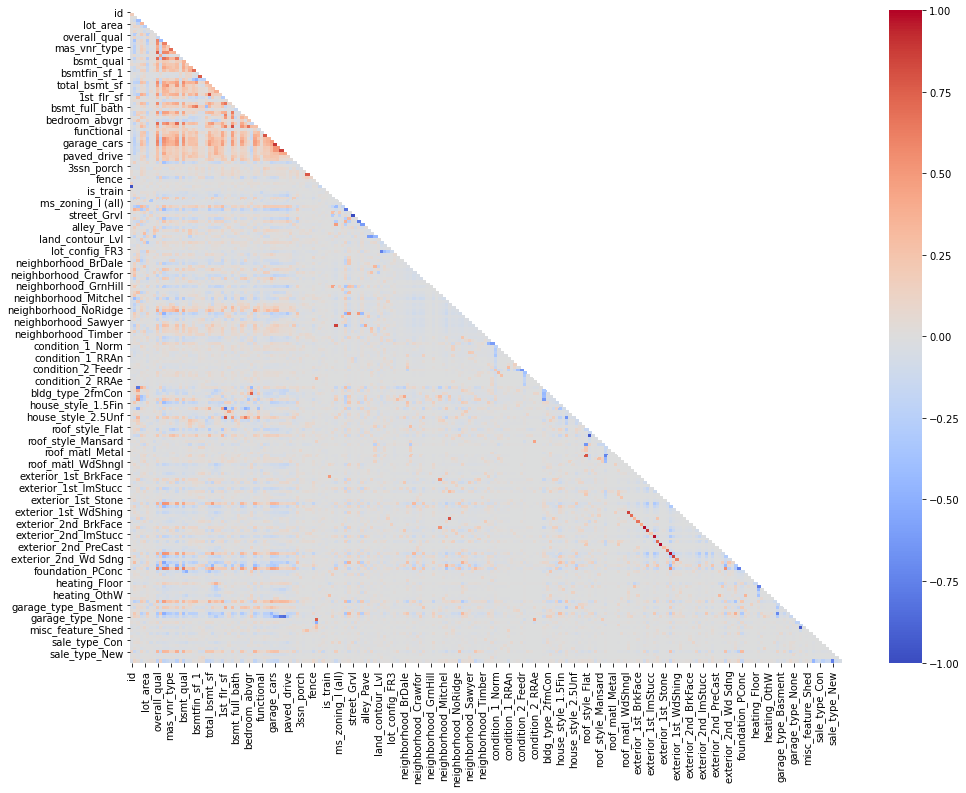

In [61]:
# #way too busy
# plt.figure(figsize=(16,12))
# mask=np.zeros_like(allofit_dum.corr())
# mask[np.triu_indices_from(mask)] = True
# sns.heatmap(allofit_dum.corr(),cmap='coolwarm', annot=False,mask=mask, vmin=-1, vmax=1);

In [242]:
training_dum.corr()[['saleprice']].sort_values('saleprice', ascending=False).head()
# 38 vars with corr >.3

,saleprice
saleprice,1.000000
overall_qual,0.816386
gr_liv_area,0.708457
bsmt_qual,0.694069
exter_qual,0.689246


In [177]:
#mod from Gwen's my_hist
def resids_hist(resids, title, x_label, y_label='Frequency', size_var = 18):
    plt.figure(figsize=(6,10));
    sns.displot(x = resids);
    plt.title(title, fontsize = size_var, pad = size_var / 2);
    plt.xlabel(x_label, fontsize = size_var, labelpad = size_var/2)
    plt.xticks(fontsize=size_var/2, rotation=45)
    plt.ylabel(y_label, fontsize = size_var, labelpad = size_var/2)
    plt.yticks(fontsize=size_var/2, rotation=90);

# Model A: Linear Regression, log-transformed y, filter by corr
First go: include all variables with corr >= 0.3
- does not account for collinearity
- definitely high variance

---
Workflow:
- Create features matrix (X), and target vector (y)
- Train, test, split
- DUMMY MODEL
- Instantiate model
- Cross validate
- Fit and Score

In [84]:
#index all features of .3 corr, drop target
corrs_over3 = training_dum.corr()['saleprice'].sort_values(ascending = False).loc[training_dum.corr()['saleprice']>.3].drop('saleprice').index
#corrs_over3   #half_bath, huh?

Index(['overall_qual', 'gr_liv_area', 'bsmt_qual', 'exter_qual',
       'kitchen_qual', 'garage_cars', 'total_bsmt_sf', 'garage_area',
       '1st_flr_sf', 'year_built', 'year_remod/add', 'full_bath',
       'garage_finish', 'foundation_PConc', 'fireplace_qu', 'heating_qc',
       'totrms_abvgrd', 'fireplaces', 'mas_vnr_area', 'bsmtfin_sf_1',
       'garage_type_Attchd', 'bsmtfin_type_1', 'mas_vnr_type', 'bsmt_exposure',
       'central_air', 'neighborhood_NridgHt', 'paved_drive', 'garage_qual',
       'exterior_1st_VinylSd', 'garage_cond', 'exterior_2nd_VinylSd',
       'open_porch_sf', 'wood_deck_sf', 'lot_frontage', 'electrical',
       'sale_type_New', 'half_bath'],
      dtype='object')

In [265]:
#TTS for local validation
X = training_dum[corrs_over3]
y = training_dum['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Dummy model A: aka Baseline model: aka Null model
Source for workflow and code: breakout discussion with Gwen

In [266]:
#manual for comprehension
#predict only mean of y_train
## INVERSE TRANSFORM Y_TRAIN HERE
dummy_train_preds = [np.expm1(np.mean(y_train))] * len(y_train)
dummy_test_preds = [np.expm1(np.mean(y_train))] * len(y_test)

In [267]:
#(squared = False) == RMSE
mean_squared_error(np.expm1(y_train), dummy_train_preds, squared=False), mean_squared_error(np.expm1(y_test), dummy_test_preds, squared=False)

(81144.18560290833, 78123.62221931538)

In [268]:
##Now with DummyRegressor tool for future repetition

In [269]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

DummyRegressor()

In [270]:
#rmse with mse & dummy_model.predict
mean_squared_error(np.expm1(y_train), np.expm1(dummy_model.predict(y_train)),squared=False), mean_squared_error(np.expm1(y_test), np.expm1(dummy_model.predict(y_test)), squared=False)

(81144.1856029074, 78123.62221931462)

In [271]:
#by function
def dummy_mod(X_train, x_test, y_train, y_test):
    dummy_model = DummyRegressor()
    dummy_model.fit(X_train, y_train)
    resids = y_test - dummy_model.predict(X_test)
   # print(f'r2: train, test = {r2_score(np.expm1(y_train), dummy_model.predict(y_train)), r2_score(np.expm1(y_test), dummy_model.predict(y_test))}')
    print(f'rmse: baseline train, test = {mean_squared_error(np.expm1(y_train), np.expm1(dummy_model.predict(y_train)),squared=False), mean_squared_error(np.expm1(y_test), np.expm1(dummy_model.predict(y_test)), squared=False)}')   
    return resids_hist(resids, title='Resids Distrib', x_label='Residuals', y_label='Frequency', size_var=18);

rmse: baseline train, test = (81144.1856029074, 78123.62221931462)


<Figure size 432x720 with 0 Axes>

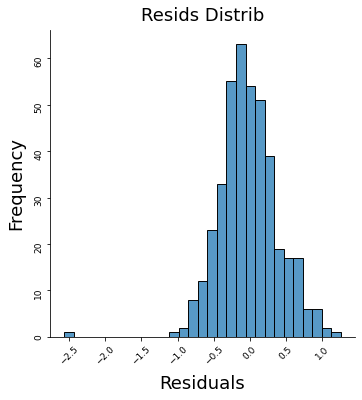

In [272]:
#test func
dummy_mod(X_train, X_test, y_train, y_test)

### Model A: instantiate, cross-val, fit, score

cross val score, mean: 0.853537
RMSE train, test:(26630.82, 26321.69)


<Figure size 432x720 with 0 Axes>

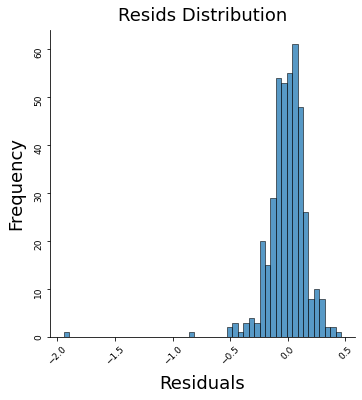

In [430]:
def linreg_fit_score(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred=lr.predict(X_test)
    resids = y_test - y_pred
    print(f'cross val score, mean: {cross_val_score(lr, X_train, y_train, cv=5).mean().round(6)}')
    print(f'RMSE train, test:{mean_squared_error(np.expm1(y_train), np.expm1(lr.predict(X_train)), squared=False).round(2), mean_squared_error(np.expm1(y_test), np.expm1(lr.predict(X_test)), squared=False).round(2)}')    
    return resids_hist(resids,title='Resids Distribution', x_label='Residuals', y_label='Frequency',size_var=18);
        
#evaluating model a: training data only   
linreg_fit_score(X_train, X_test, y_train, y_test)

#### For submission: using Actual Test Set

In [190]:
X_cols = [corrs_over3]
y = training_dum['saleprice']

In [209]:
def linreg_submit(train_df, X_cols, y, test_df, version):
    lr = LinearRegression()
    lr.fit(train_df[X_cols], y)  #no tts splits here, that was just for local validation
    test_preds = np.expm1(lr.predict(test_df[X_cols])) #exponentiate output
    kaggle_submission = {
        'Id' : test_df['id'],
        'SalePrice' : test_preds
    }
    kaggle_submission = pd.DataFrame(kaggle_submission)
    kaggle_submission.to_csv('./kaggle_submissions_all/'+version+'.csv',index=False)
    return kaggle_submission.tail(10)


In [210]:
#train_df = training_dum, test_df = testing_clean
#linreg_submit(train_df = training_dum, X_cols = corrs_over3, y= training_dum['saleprice'], test_df = testing_clean, version = 'LRv1')
# SUBMITTED 4/13/21. Kaggle Score 24426.01049

,Id,SalePrice
868,337,183281.301350
869,2765,143175.593305
870,1746,285308.330156
871,368,304848.175956
872,2806,207445.199595
873,1662,185881.667154
874,1234,210763.176727
875,1373,133301.914123
876,1672,113335.610463
877,1939,128053.254719


# Model B: A + log-transform all numerical vars with skew>.5
---
### Just like for [saleprice]
---
##### Following steps from sources 3 and 4.

In [215]:
allofit_basic_clean.head() #combo training + test data, but no saleprice

In [218]:
#isolate numerical vs categorical vars
cats = allofit_basic_clean.select_dtypes(include= ['object']).columns
nums = allofit_basic_clean.select_dtypes(exclude= ['object']).columns
all_cats = allofit_basic_clean[cats]
all_nums = allofit_basic_clean[nums]

In [233]:
#find skewed numeric features.  Code from source 3, and 4
#"general rule of thumb, abv(skew)>.5 is 'moderately skewed'" - source 3
idskew = all_nums.loc[all_nums['is_train']==1].apply(lambda x: skew(x))  #on training data only!
idskew = idskew[abs(idskew)>0.5] #filter to threshold (.5)
idskew_cols = idskew.index  #col names of skewed training vars, now reincorporate testing data

In [235]:
all_nums[idskew_cols] = np.log1p(all_nums[idskew_cols])

In [236]:
#combine nums with categoricals, then split to test / train again
interim = pd.concat([all_nums, all_cats], axis=1)
y = training_dum['saleprice']
training_logged = pd.concat([interim.loc[interim['is_train']==1],y], axis=1)
testing_logged = interim.loc[interim['is_train'] != 1]

##### Rerun correlation with new data; tts X and y

In [247]:
#training_logged.corr()[['saleprice']].sort_values('saleprice', ascending=False).head()
#pretty similar to untransformed list

In [246]:
corrs_over3_log = training_logged.corr()['saleprice'].sort_values(ascending = False).loc[training_logged.corr()['saleprice']>.3].drop('saleprice').index

In [256]:
#TTS for local validation
X = training_logged[corrs_over3]
y = training_logged['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

##### dummy model

rmse: baseline train, test = (81144.1856029074, 78123.62221931462)


<Figure size 432x720 with 0 Axes>

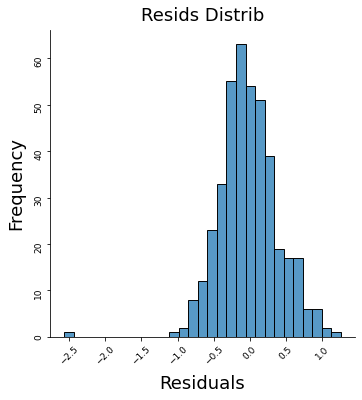

In [257]:
dummy_mod(X_train, X_test, y_train, y_test)  #identical to dummy of no transformed numericals...

cross val score, mean: 0.894535
RMSE train, test:(23748.92, 22327.47)


<Figure size 432x720 with 0 Axes>

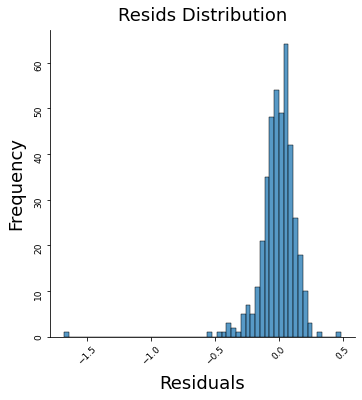

In [264]:
#evaluate model b, training data only
linreg_fit_score(X_train, X_test, y_train, y_test)  #better RMSE test than A, worse train...

# Model C: A + log-transform ONLY continuous vars with skew>.5.  Do not transform discrete numeric vars.

##### Hold on submitting model B, see if C superior

In [380]:
#discretios = discrete numeric vars defined above in your stretching of the scale:
#start with same process as model B
cats = allofit_basic_clean.select_dtypes(include= ['object']).columns
nums = allofit_basic_clean.select_dtypes(exclude= ['object']).columns
all_cats = allofit_basic_clean[cats]
all_nums = allofit_basic_clean[nums]

In [381]:
idskew = all_nums.loc[all_nums['is_train']==1].apply(lambda x: skew(x))  #on training data only!
idskew = idskew[abs(idskew)>0.5]

In [382]:
#not all discretios are in list of skewed nums
#which ones are?
def drop_discretios(skewlist, discretes):
    fixed=[]
    for i in discretes:
        if i in skewlist:
            fixed.append(i)
    return fixed

In [383]:
tofilter = drop_discretios(idskew, discretios)

In [384]:
#remove discrete vars from list of skew-to-be-transformed
idskew.drop(tofilter, inplace=True)
idskew_cols = idskew.index  #col names of skewed training vars, now reincorporate testing data

In [386]:
all_nums[idskew_cols] = np.log1p(all_nums[idskew_cols])

In [387]:
#combine nums with categoricals, then split to test / train again
interim = pd.concat([all_nums, all_cats], axis=1)
y = training_dum['saleprice']
training_contlog = pd.concat([interim.loc[interim['is_train']==1],y], axis=1)
testing_contlog = interim.loc[interim['is_train'] != 1]

##### Rerun corr, tts

In [390]:
training_contlog.corr()[['saleprice']].sort_values('saleprice', ascending=False).head()
#still pretty similar to untransformed list
corrs_over3_contlog = training_contlog.corr()['saleprice'].sort_values(ascending = False).loc[training_contlog.corr()['saleprice']>.3].drop('saleprice').index

#this is the same list of vars as corrs_over3.
#log transform did not effect correlation of vars to target
#difference between models is discrete vars are now NOT log transformed, unlike model B
#does this make a difference?

In [401]:
#TTS for local validation
X = training_contlog[corrs_over3_contlog]
y = training_contlog['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

rmse: baseline train, test = (81144.1856029074, 78123.62221931462)


<Figure size 432x720 with 0 Axes>

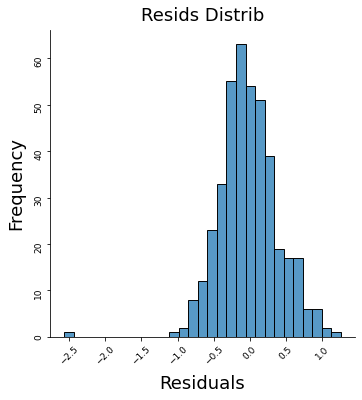

In [402]:
dummy_mod(X_train, X_test, y_train, y_test)

cross val score, mean: 0.893182
RMSE train, test:(22744.75, 21349.45)


<Figure size 432x720 with 0 Axes>

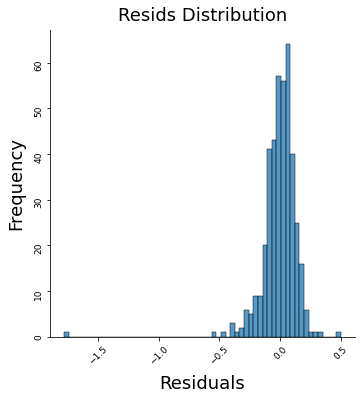

In [403]:
linreg_fit_score(X_train, X_test, y_train, y_test)  #RMSE train same as A, test better...

In [404]:
#### For submission: using Actual Test Set
X_cols = [corrs_over3_contlog]
y = training_dum['saleprice']

In [409]:
#linreg_submit(train_df = training_contlog, X_cols = corrs_over3_contlog, y= training_dum['saleprice'], test_df = testing_contlog, version = 'LRv2')
# SUBMITTED 4/13/21. Kaggle Score 23339.00799

,Id,SalePrice
868,337,172335.300110
869,2765,158585.133949
870,1746,252868.920202
871,368,308521.332087
872,2806,203203.282801
873,1662,176863.384884
874,1234,208747.904851
875,1373,136621.041717
876,1672,112468.372428
877,1939,120769.029702


### Model D: Model C but only top 10 most correlated features
Nope, worse.  

In [425]:
# training_contlog.corr()[['saleprice']].sort_values('saleprice', ascending=False).head(11)
# corrs10_contlog = training_contlog.corr()['saleprice'].sort_values(ascending=False)[:11].drop('saleprice').index

In [432]:
# X = training_contlog[corrs10_contlog]
# y = training_contlog['saleprice']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
# linreg_fit_score(X_train, X_test, y_train, y_test)

# Ridge
Nothing fancy - no polynomials or feature combining/creation to address collinearity and interaction.  Just the above, fit into ridge regularization method working through steps from source 3 and class.

In [452]:
#from superior of above models: Model C
X = training_contlog[corrs_over3_contlog]
y = training_contlog['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [455]:
r_alphas = np.logspace(0,5,100)
ridge= RidgeCV(alphas=r_alphas)
ridge.fit(X_train, y_train)
alpha1=ridge.alpha_
alpha1

2.535364493970112

In [457]:
#try again for more precision with alphas centered around the above output
ridge = RidgeCV(alphas = np.linspace(0,5,100), cv=10)
ridge.fit(X_train, y_train)
alpha2 = ridge.alpha_
alpha2

3.5858585858585856

In [462]:
#ridge rmse train, test.  Baaarely better than lr.  Try lasso?
mean_squared_error(np.expm1(y_train), np.expm1(ridge.predict(X_train)), squared=False).round(2), mean_squared_error(np.expm1(y_test), np.expm1(ridge.predict(X_test)), squared=False).round(2)  

(22734.76, 21157.91)

# LASSO
Nothing fancy - no polynomials or feature combining/creation to address collinearity and interaction.  Just the above, fit into lasso regularization method working through steps from class.

In [465]:
#from superior of above models: Model C
X = training_contlog[corrs_over3_contlog]
y = training_contlog['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [466]:
# ss = StandardScaler()
# Z_train = ss.fit_transform(X_train)
# Z_test = ss.transform(X_test)

In [469]:
lasso_alphas = np.logspace(-3,0,1000)
lasso = LassoCV(alphas=lasso_alphas, cv=5) #cv over list of lasso alphas
lasso.fit(X_train, y_train)
lasso.alpha_ #optimal alpha (aka lambda)

0.001

In [470]:
#r2
lasso.score(X_train, y_train), lasso.score(X_test, y_test)  #R2 for training & test

(0.8999341958119992, 0.8662637312979459)

In [471]:
#RMSE - better than lr and ridge
mean_squared_error(np.expm1(y_train), np.expm1(lasso.predict(X_train)), squared=False).round(2), mean_squared_error(np.expm1(y_test), np.expm1(lasso.predict(X_test)), squared=False).round(2)  

(22963.75, 20842.86)

In [473]:
#for submission:
lasso.fit(X, y)
test_preds = np.expm1(lasso.predict(testing_contlog[corrs_over3_contlog])) #exponentiate output
kaggle_submission = {
    'Id' : testing_contlog['id'],
    'SalePrice' : test_preds
}
kaggle_submission = pd.DataFrame(kaggle_submission)
kaggle_submission.tail(10)

,Id,SalePrice
868,337,168034.054389
869,2765,159311.838493
870,1746,252845.696047
871,368,307822.430513
872,2806,204357.282787
873,1662,173613.152175
874,1234,212432.423203
875,1373,134372.906814
876,1672,110845.315132
877,1939,119049.914378


In [474]:
#kaggle_submission.to_csv('./kaggle_submissions_all/Lasso_v1.csv',index=False)
#submitted 4/13/21  Kaggle score = 23507.89650
#not better than lr!  need to scale and use z-scores or is that only with classification?